#Project : Super Resolution with GANs and FastAI

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

#Load and transform data

In [0]:
bs = 128
size = 64
def get_data(bs,size):
    return (ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)
              .label_from_func(lambda x: path_hr/x.name)
              .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
              .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

#Crappify the images

In [0]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr
        
    def __call__(self, fn, i):
        dest = self.path_lr/fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz,resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [4]:
crappify = crappifier(path_lr,path_hr)
il = ImageList.from_folder(path_hr)
parallel(crappify, il.items)

In [0]:
data = get_data(bs, size)

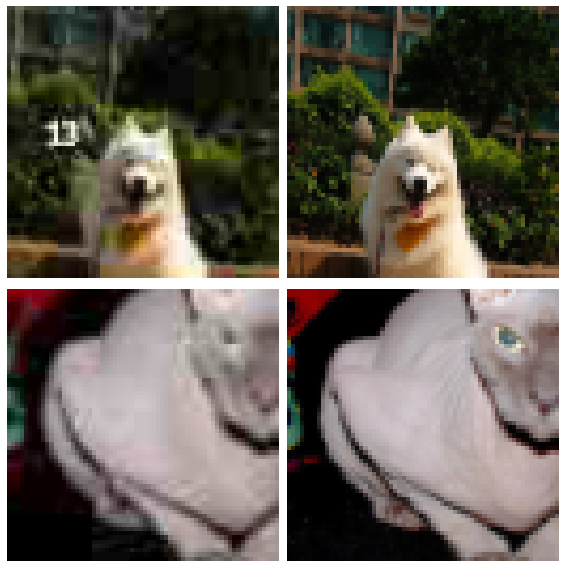

In [6]:
data.show_batch(2)

#Create Generator 

In [7]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()
arch = models.resnet34
def create_gen_learner():
    return unet_learner(data,
                        arch, wd=wd,
                        blur=True,
                        norm_type=NormType.Weight,
                        self_attention=True,
                        y_range=y_range,
                        loss_func=loss_gen)
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


#Train the generator

In [8]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.285513,0.066482,01:03
1,0.105833,0.042627,01:00


epoch,train_loss,valid_loss,time
0,0.034453,0.036556,01:01
1,0.031520,0.032475,01:01
2,0.029874,0.032011,01:01


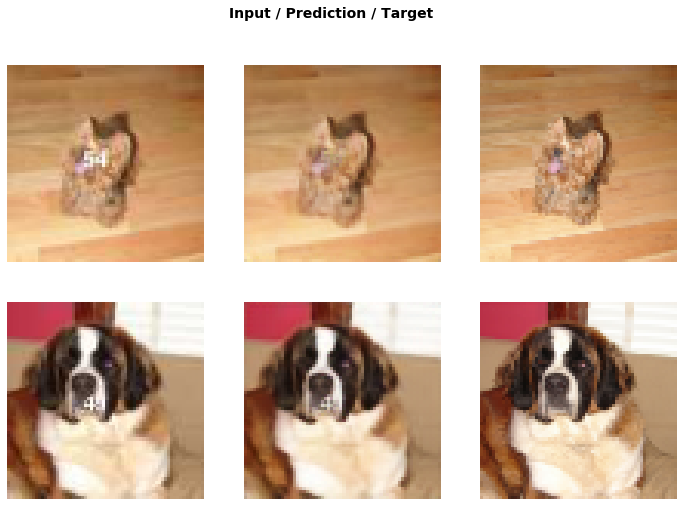

In [9]:
learn_gen.unfreeze()
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))
learn_gen.show_results(rows=2)
learn_gen.save('gen-pre2')

#Save generated images

In [0]:
name_gen = 'image_gen'
path_gen = path/name_gen
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1
save_preds(data.fix_dl)

#Create Discriminator

In [0]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size).databunch(bs=bs).normalize(imagenet_stats))
    return data

data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

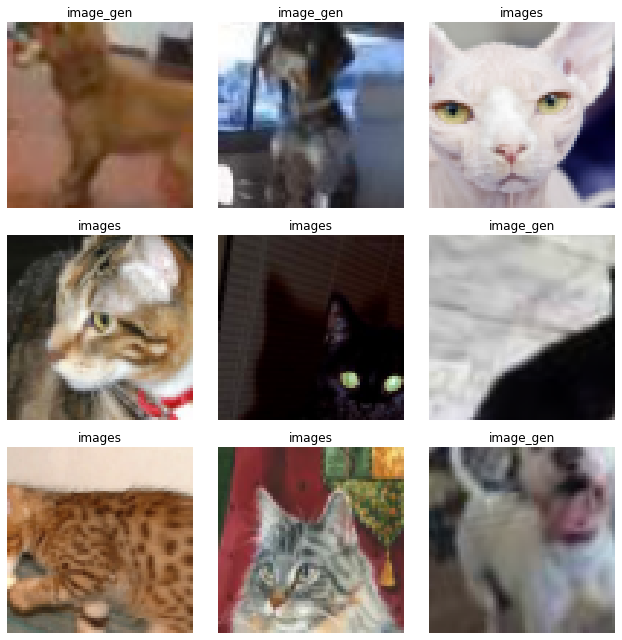

In [14]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

#Train Discriminator

In [16]:
learn_critic.fit_one_cycle(6, 1e-3)
learn_critic.save('critic-pre2')

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.691937,0.691232,0.509971,01:07
1,0.675405,0.698922,0.552707,01:05
2,0.606556,1.097310,0.579772,01:05
3,0.485024,0.829341,0.611111,01:05
4,0.404943,0.737703,0.638889,01:05
5,0.377515,0.816883,0.597578,01:05


In [0]:
learn_crit=None
learn_gen=None

data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')
learn_gen = create_gen_learner().load('gen-pre2')

#Create GAN

In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, 
                                 learn_crit, 
                                 weights_gen=(1.,50.),        
                                 show_img=False, 
                                 switcher=switcher,    
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

#Train GAN

In [20]:
lr = 1e-4
learn.fit(40,lr)

#Show Results

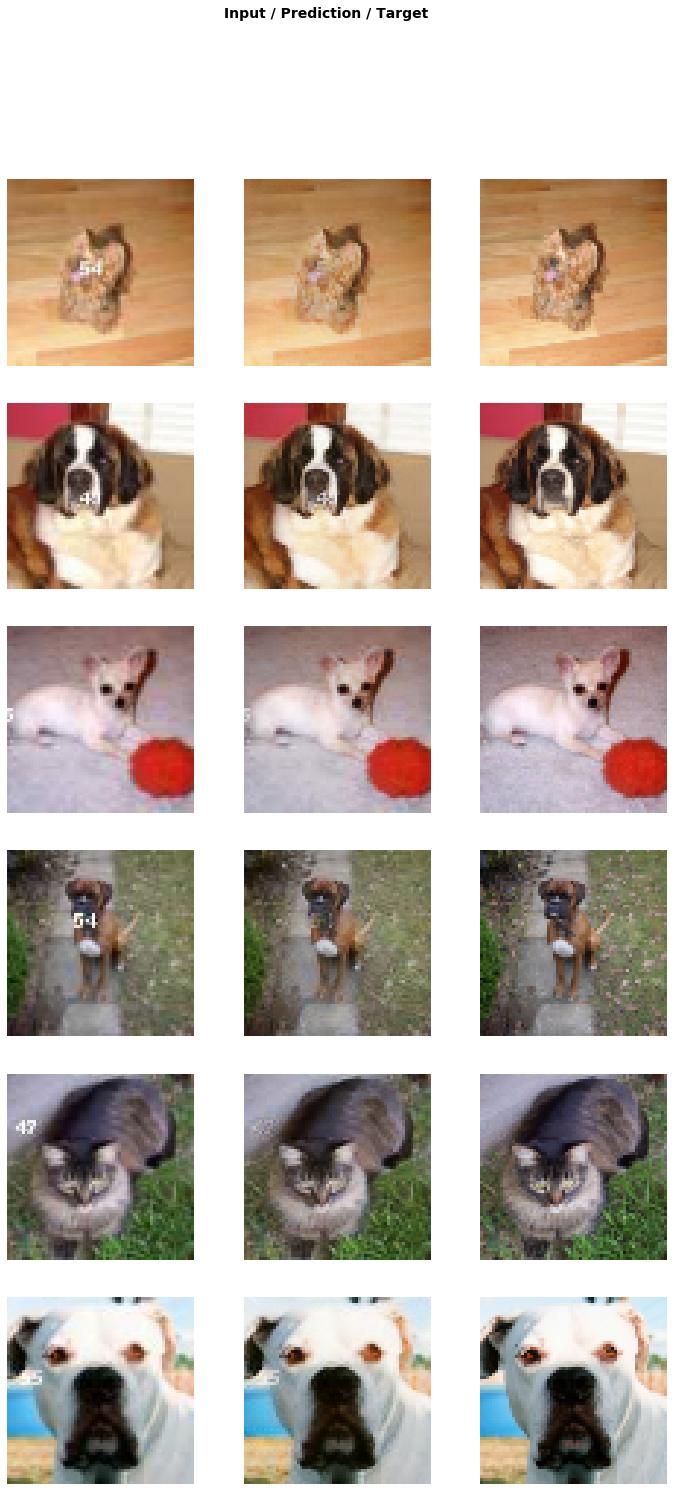

In [23]:
learn.show_results(rows=6)

In [24]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'reversed_course/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from pathlib import Path
base_dir = root_dir + 'reversed_course/'
path = Path(base_dir + 'data')
folder = 'model_weights/gan'
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [26]:
ls

gdrive/  sample_data/


In [27]:
learn.save(dest/'gan-weight',return_path=True)

PosixPath('/content/gdrive/My Drive/reversed_course/data/model_weights/gan/gan-weight.pth')